In [304]:
import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import keras
import urllib.request
import zipfile
import os.path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# -- Keras Import
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing import image

from keras.datasets import imdb
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU, SimpleRNN

from keras.layers import Activation, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [11]:
# Global variables
url_loc = 'https://os.unil.cloud.switch.ch/fma/fma_metadata.zip'
file_loc = './data/fma_metadata.zip'
dir_unzip_loc = './data/'

data_length = 5000

In [12]:
# Download zipped fma meta data
if not os.path.isfile(file_loc):
    urllib.request.urlretrieve(url_loc, file_loc)

In [14]:
# Unzip fma meta data
if not os.path.isdir(dir_unzip_loc):
    with zipfile.ZipFile(file_loc, 'r') as zip_ref:
        zip_ref.extractall(dir_unzip_loc)

In [205]:
feat_header = pd.read_csv(dir_unzip_loc + "fma_metadata/features.csv", header=None, nrows=3)
feat_header = feat_header.transpose(copy = True)
name = []
for index, row in tfh.iterrows():
    name.append(row[0]+"#"+row[1]+"#"+row[2])
name[0] = "track_id"

df_tracks = pd.read_csv(dir_unzip_loc + "fma_metadata/tracks.csv", skiprows=[0,2]);
df_features = pd.read_csv(dir_unzip_loc + "fma_metadata/features.csv", header = None, names= a ,skiprows=4);
# df_features = pd.read_csv(dir_unzip_loc + "fma_metadata/features.csv", header = None, names= a ,skiprows=4, nrows=data_length);
df_genres = pd.read_csv(dir_unzip_loc + "fma_metadata/genres.csv", skiprows=0, nrows=data_length);

df_tracks = df_tracks.rename(columns={ df_tracks.columns[0]: "track_id" })
df_features = df_features.rename(columns={ df_features.columns[0]: "track_id" })
1

1

In [202]:
df_tracks.head()

,track_id,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,information.1,interest,language_code,license,listens.1,lyricist,number,publisher,tags.2,title.1
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [206]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
track_id             106574 non-null int64
comments             106574 non-null int64
date_created         103045 non-null object
date_released        70294 non-null object
engineer             15295 non-null object
favorites            106574 non-null int64
id                   106574 non-null int64
information          83149 non-null object
listens              106574 non-null int64
producer             18060 non-null object
tags                 106574 non-null object
title                105549 non-null object
tracks               106574 non-null int64
type                 100066 non-null object
active_year_begin    22711 non-null object
active_year_end      5375 non-null object
associated_labels    14271 non-null object
bio                  71156 non-null object
comments.1           106574 non-null int64
date_created.1       105718 non-null object
favorites.1          1065

By looking at the info, we can say following things:
1. track_id column doesn't have any value which is no non numeric value. otherwise it would have parsed as object not as int64. 
1. genre_top column has less number of values, however at the same time genres and genres_all have same value as the track_id which implies if there are no missing values in track_id. Then the genre_top value are the only genres which are only single for one song. Because genre_top only account for the pure genre type of songs while the genre type if for all genres associated with the perticular song. So we are going to focus on this as our classification target.
1. We can see there are 30% of missing values for release date for an album (date_released) which is around 70 percent. Which can fairly give us the idea what period of songs were targeted while making the dataset. 

In [218]:
df_tracks.track_id.isnull().sum()

0

We can see there are no null values for the track_id column

## Features Table

In [83]:
df_features.head()

,track_id,chroma_cens#kurtosis#01,chroma_cens#kurtosis#02,chroma_cens#kurtosis#03,chroma_cens#kurtosis#04,chroma_cens#kurtosis#05,chroma_cens#kurtosis#06,chroma_cens#kurtosis#07,chroma_cens#kurtosis#08,chroma_cens#kurtosis#09,...,tonnetz#std#04,tonnetz#std#05,tonnetz#std#06,zcr#kurtosis#01,zcr#max#01,zcr#mean#01,zcr#median#01,zcr#min#01,zcr#skew#01,zcr#std#01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [285]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr#std#01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


If there is any missing value while the feature extraction

In [286]:
df_features.isnull().sum().unique()

array([0])

By looking above we can say that there are no feature which data has net been extracted.

---
### Merging the tables
Takeing only the data which we need for training the model.

In [287]:
df_tracks_only_genre = df_tracks[['genre_top','track_id']]
df_tracks_only_genre_with_id = pd.merge(df_tracks_only_genre, df_genres, left_on="genre_top", right_on="title", how='inner')
df_tracks_only_genre_with_id = df_tracks_only_genre_with_id[['genre_id','track_id']]
df_tracks_only_genre_with_id.head()

,genre_id,track_id
0,21,2
1,21,3
2,21,5
3,21,134
4,21,583


In [317]:
# Merge
df = pd.merge(df_tracks_only_genre_with_id, df_features, on ="track_id", how='inner')
df.head()

,genre_id,track_id,chroma_cens#kurtosis#01,chroma_cens#kurtosis#02,chroma_cens#kurtosis#03,chroma_cens#kurtosis#04,chroma_cens#kurtosis#05,chroma_cens#kurtosis#06,chroma_cens#kurtosis#07,chroma_cens#kurtosis#08,...,tonnetz#std#04,tonnetz#std#05,tonnetz#std#06,zcr#kurtosis#01,zcr#max#01,zcr#mean#01,zcr#median#01,zcr#min#01,zcr#skew#01,zcr#std#01
0,21,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,21,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,21,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,21,134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,...,0.058766,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623
4,21,583,-0.028032,0.509161,0.067235,0.465656,-0.448363,1.086958,-0.103174,-0.247502,...,0.058434,0.018185,0.017061,2.111479,0.270508,0.036760,0.025879,0.000977,1.296176,0.033785


### Null Value check

In [318]:
df.isnull().sum().unique()

array([0])

It seems there are no null values

### Target Distribution

In [319]:
df.genre_id.unique().size

16

We can see that there are total 14 unique types of genres.

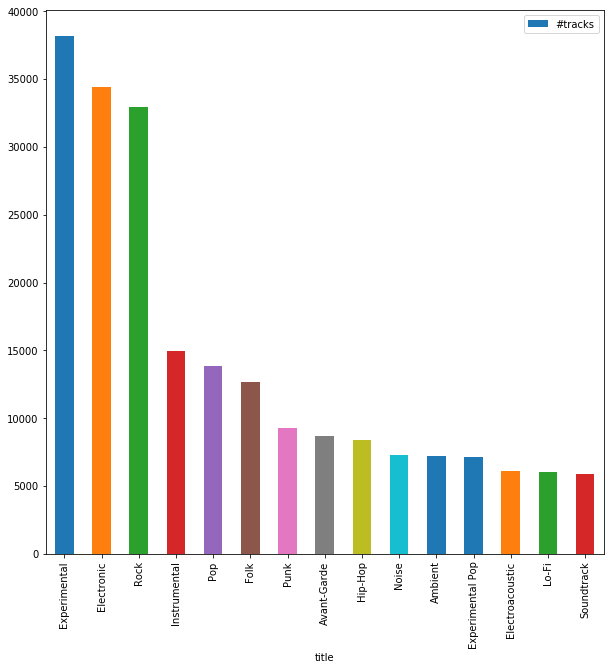

In [200]:
df_genres.sort_values(by="#tracks",ascending=False).head(15).plot(x="title", y="#tracks", kind="bar", figsize=[10,10])

We can see that our data doesn't have a uniform distribution. Half of the dataset is Rock.

---
### Song Language Distribution

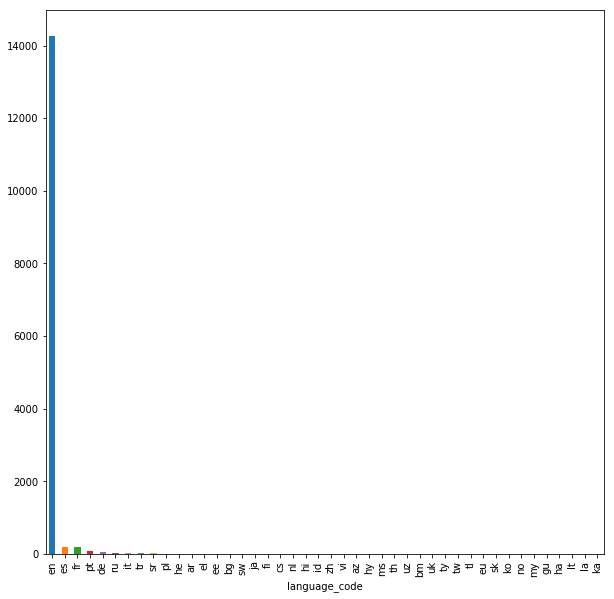

In [204]:
df_tracks["language_code"].groupby(df_tracks["language_code"]).count().sort_values(ascending=False).plot(kind="bar", figsize=[10,10])

language_code code has lot of missing values which is almost 85%. That means this is not a good variable for taking account unless our data sample has some consideration for the songs language. From the above graph we can say the our data has almost english songs. Let's have finner look at the numbers songs of different languages we have.

---
## Audio Feature Distribution

### Zero crossing Rate

Let's check the fundamental frequencies for the songs.

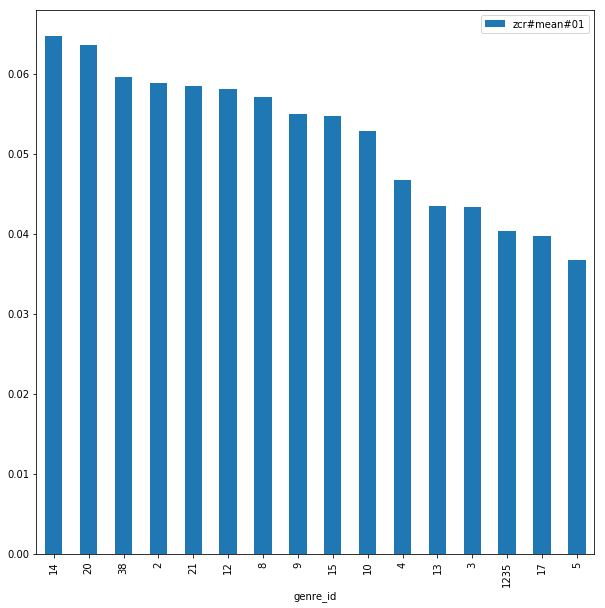

In [298]:
df[["zcr#mean#01"]].groupby(df["genre_id"]).mean().sort_values(by = "zcr#mean#01",ascending=False).head(20).plot(kind="bar", figsize=[10,10])

We can see that zero crossing rate for some songs are clearly higher than the other ones. Which means the genres with higher vale has higher overall frequency than the lower one. which may imply the use of musical instruments with higher frequencies.

---
### RMSE root-mean-square energy

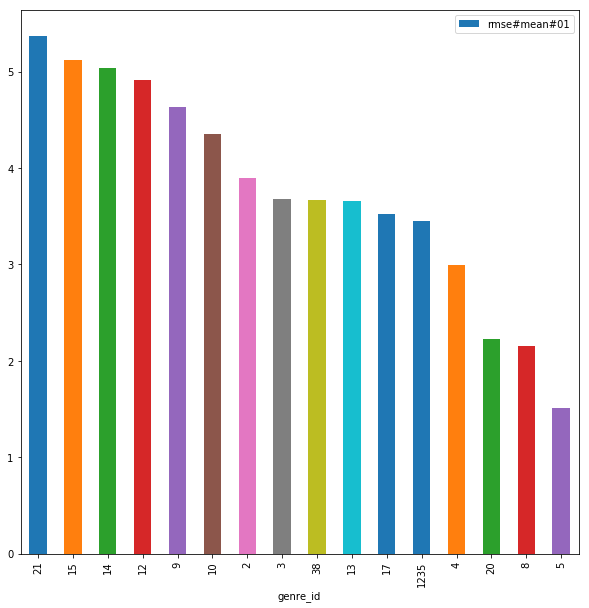

In [327]:
df[["rmse#mean#01","genre_id"]].groupby(df["genre_id"]).mean().sort_values(by = "rmse#mean#01",ascending=False).head(30).plot(x="genre_id", y="rmse#mean#01", kind="bar", figsize=[10,10])

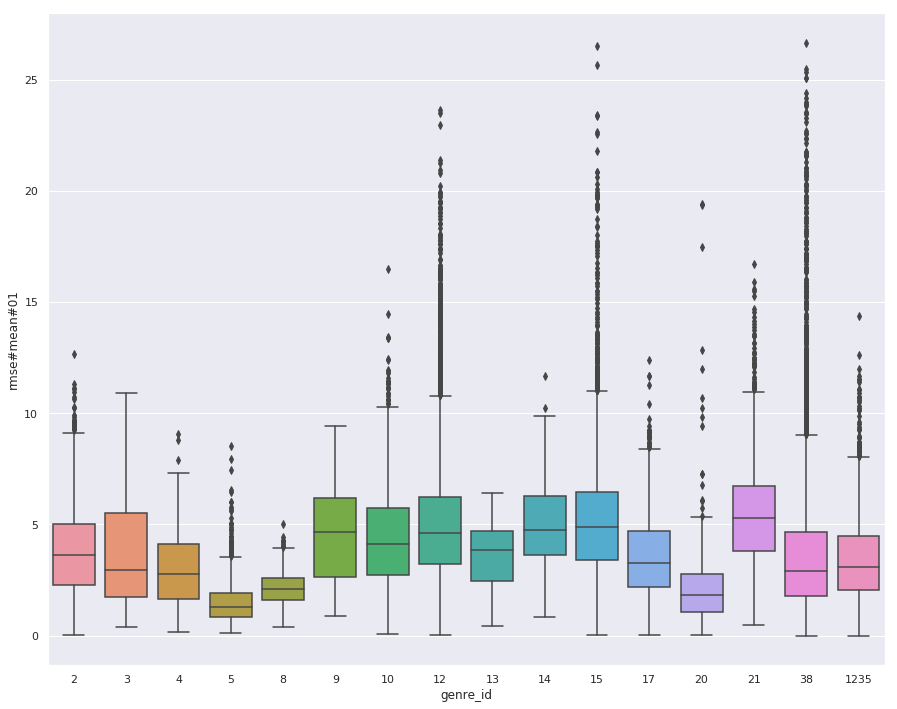

In [328]:
sns.set(rc={'figure.figsize':(15,12)})
sns.boxplot(x="genre_id", y="rmse#mean#01", data=df);

From the above graphs we can see that some songs have more silence in them than the other songs. Here we can see that some genres clearly have more silence in them than the other genres.

---
### Spectral Centroid

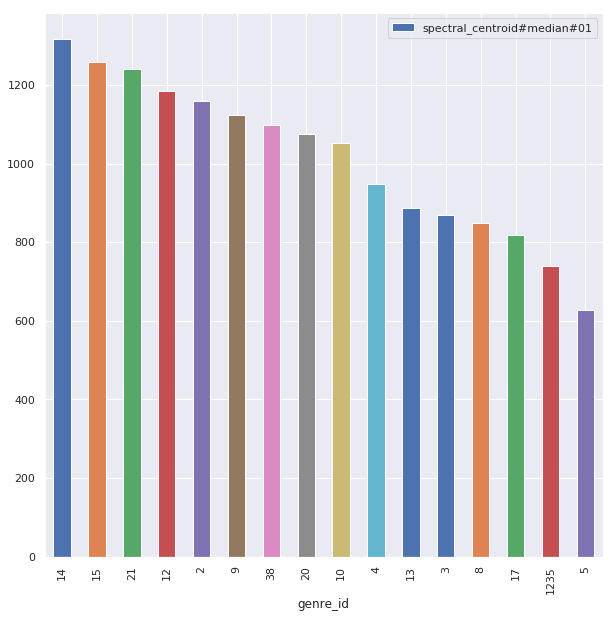

In [330]:
df[["spectral_centroid#median#01","genre_id"]].groupby(df["genre_id"]).mean().sort_values(by = "spectral_centroid#median#01",ascending=False).head(30).plot(x="genre_id", y="spectral_centroid#median#01", kind="bar", figsize=[10,10])

From spectral centroid seems a very good distinguishing factor for desiding as it tells the wheres the centre of mass of the centroid located. And it seems number of songs are pretty biased towards the weight of the songs or the brightness of the songs.